<h1 style="text-align: center;">TOPIC MODELING FOR HACK MY ROBOT USING BERTopic</h1>

This notebook presents the topic modeling process employed to analyze data from past Hack My Robot (HMR) competitions. The dataset, stored in the **"Responses.xlsx"** file, contains all the data gathered from the previous editions of HMR and should be updated following each new edition of the competition. After updating the dataset, all following cells should be run until the **"Topic modeling and screening"** section. Starting from this section, there are manual interventions, such as merging similar topics and removing irrelevant topics. Therefore, the cells from this point should be run one by one, making the necessary changes.       

In [2]:
# Install the required libraries
!pip install pandas matplotlib spacy bertopic scikit-learn gensim umap-learn hdbscan openai tiktoken nltk sentence-transformers numpy kaleido plotly 
!python -m spacy download en_core_web_sm

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 59.6/59.6 kB 795.7 kB/s eta 0:00:00
  Created wheel for fst-pso: filename=fst_pso-1.8.1-py3-none-any.whl size=20451 sha256=74b08697b64e69159ae737c784aa692ad4d66c9c4b805152480d4d96176a2145
  Stored in directory: c:\users\semih\appdata\local\pip\cache\wheels\69\f5\e5\18ad53fe1ed6b2af9fad05ec052e4acbac8e92441df44bad2e
  Created wheel for miniful: filename=miniful-0.0.6-py3-none-any.whl size=3517 sha256=b14481e069a9e9d4d0067b633ffea06fc9a5d8cdfe7f6eba612e41851ad9a9d8
  Stored in directory: c:\users\semih\appdata\local\pip\cache\wheels\9d\ff\2f\afe4cd56f47de147407705626517d68bea0f3b74eb1fb168e6
Successfully built fst-pso miniful


     ---------------------------------------- 12.8/12.8 MB 9.9 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [78]:
# Import the required libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.representation import KeyBERTInspired
from bertopic.representation import MaximalMarginalRelevance, OpenAI
from openai import OpenAI
import tiktoken
import itertools
import numpy as np
import re
import nltk
from nltk.tokenize import sent_tokenize
from sentence_transformers import SentenceTransformer
import spacy
import csv
import configparser
import plotly.io as pio

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\semih\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Text Segmentation

In this section, the raw data is segmented into smaller pieces to be used for topic modeling in the later stages. Different methods for segmentation were experimented to find the best option for our use case. 
## Sentence segmentation using the NLTK library:

In [52]:
# Function to segment text into sentences using NLTK and clean up the sentences
def segment_text_into_sentences_nltk(text):
    # Remove newline characters and replace them with a space
    cleaned_text = text.replace('\n', ' ')
    sentences = sent_tokenize(cleaned_text)
    # Clean each sentence from leading numbers, hyphens, asterisks, parentheses, colons, and periods
    cleaned_sentences = [re.sub(r'^[\d\-*):.,]+', '', sentence).strip() for sentence in sentences]
    return cleaned_sentences

# Read the Excel file
df = pd.read_excel('Responses.xlsx', engine='openpyxl')

# Initialize a DataFrame to store all valid sentences with additional metadata
all_sentences = []

# Process each row in the DataFrame
for _, row in df.iterrows():
    sentences = segment_text_into_sentences_nltk(row['concat'])
    for sentence in sentences:
        if len(sentence.split()) > 1:  # Ensure the sentence has more than one word
            all_sentences.append({
                'Team No': row['team_no'],
                'Year': row['year'],
                'Segmented Text': sentence
            })

# Convert the list of dictionaries to a DataFrame
sentence_df = pd.DataFrame(all_sentences)

# Save all sentences to a CSV file
sentence_df.to_csv('segmented_text_by_sentences_nltk.csv', index=False)

print("All valid sentences have been written to segmented_text_by_sentences_nltk.csv")

All valid sentences have been written to segmented_text_by_sentences_nltk.csv


## Sentence segmentation using the SpaCy library:

In [53]:
# Load spaCy's English tokenizer
nlp_spacy = spacy.load('en_core_web_sm')

# Function to segment text into sentences using spaCy and clean up the sentences
def segment_text_into_sentences_spacy(text):
    # Remove newline characters and replace them with a space
    cleaned_text = text.replace('\n', ' ')
    doc = nlp_spacy(cleaned_text)  # Use the renamed NLP object
    # Clean each sentence from leading numbers, hyphens, asterisks, parentheses, colons, and periods
    cleaned_sentences = [re.sub(r'^[\d\-*):.,]+', '', sent.text).strip() for sent in doc.sents]
    return cleaned_sentences

# Read the Excel file
df = pd.read_excel('Responses.xlsx', engine='openpyxl')

all_sentences_spacy = []

# Process each row in the DataFrame
for _, row in df.iterrows():
    sentences = segment_text_into_sentences_spacy(row['concat'])
    for sentence in sentences:
        if len(sentence.split()) > 1:  # Ensure the sentence has more than one word
            all_sentences_spacy.append({
                'Team No': row['team_no'],
                'Year': row['year'],
                'Segmented Text': sentence
            })
            
            
# Convert the list of dictionaries to a DataFrame
sentence_df_spacy = pd.DataFrame(all_sentences_spacy)

# Save all sentences to a CSV file
sentence_df_spacy.to_csv('segmented_text_by_sentences_spacy.csv', index=False)

print("All valid sentences have been written to segmented_text_by_sentences_spacy.csv")

All valid sentences have been written to segmented_text_by_sentences_spacy.csv


## Semantic segmentation for various similarity threshold values

### Semantic segmentation using SBERT and the sentence boundary detection of the NLTK library:

In [54]:
# Load the SentenceTransformers model (SBERT)
model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to segment text based on a given semantic similarity threshold
def segment_text_nltk(text, similarity_threshold):
    # Remove newline characters and replace them with a space
    cleaned_text = text.replace('\n', ' ')
    
    # Use NLTK to tokenize sentences
    sentences = sent_tokenize(cleaned_text)
    
    # Clean each sentence from specified characters at the beginning
    sentences = [re.sub(r'^[\d\-*):.]+', '', sent.strip()) for sent in sentences]
    
    # Generate embeddings using the SentenceTransformers model
    embeddings = model.encode(sentences)
    segment_boundaries = [0]
    
    # Calculate cosine similarity of consecutive sentences to identify segment boundaries
    for i in range(len(embeddings) - 1):
        similarity = np.dot(embeddings[i], embeddings[i + 1]) / (np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[i + 1]))
        if similarity < similarity_threshold:
            segment_boundaries.append(i + 1)
    segment_boundaries.append(len(sentences))
    
    segments = []
    for i in range(len(segment_boundaries) - 1):
        start, end = segment_boundaries[i], segment_boundaries[i + 1]
        segment_text_nltk = ' '.join(sentences[start:end])
        if len(segment_text_nltk.split()) > 3:  # Ensure the segment has more than three words (to avoid too short segments)
            segments.append(segment_text_nltk)
    return segments

# Similarity threshold values to try
threshold_values = np.arange(0.1, 0.75, 0.05)

# Create a new directory to store the CSV files
output_dir = 'semantic_segmentation_sbert_nltk'
os.makedirs(output_dir, exist_ok=True)

# Segmentation for each similarity threshold value
for threshold in threshold_values:
    all_segments = []  # Initialize inside the loop to reset for each threshold
    # Process each row in the DataFrame
    for _, row in df.iterrows():
        segments = segment_text_nltk(row['concat'], threshold)
        for segment in segments:
            all_segments.append({
                'Team No': row['team_no'],
                'Year': row['year'],
                'Segmented Text': segment
            })
    
    # Convert the list of dictionaries to a DataFrame
    segment_df = pd.DataFrame(all_segments)
    
    # Save all segments to a CSV file, including the threshold in the filename
    filename = os.path.join(output_dir, f'semantic_segmentation_sbert_nltk_{threshold:.2f}.csv')
    segment_df.to_csv(filename, index=False)
    
    print(f"All segments have been written for threshold {threshold:.2f} in {filename}")

All segments have been written for threshold 0.10 in semantic_segmentation_sbert_nltk\semantic_segmentation_sbert_nltk_0.10.csv
All segments have been written for threshold 0.15 in semantic_segmentation_sbert_nltk\semantic_segmentation_sbert_nltk_0.15.csv
All segments have been written for threshold 0.20 in semantic_segmentation_sbert_nltk\semantic_segmentation_sbert_nltk_0.20.csv
All segments have been written for threshold 0.25 in semantic_segmentation_sbert_nltk\semantic_segmentation_sbert_nltk_0.25.csv
All segments have been written for threshold 0.30 in semantic_segmentation_sbert_nltk\semantic_segmentation_sbert_nltk_0.30.csv
All segments have been written for threshold 0.35 in semantic_segmentation_sbert_nltk\semantic_segmentation_sbert_nltk_0.35.csv
All segments have been written for threshold 0.40 in semantic_segmentation_sbert_nltk\semantic_segmentation_sbert_nltk_0.40.csv
All segments have been written for threshold 0.45 in semantic_segmentation_sbert_nltk\semantic_segmentat

### Semantic segmentation using SBERT and the sentence boundary detection of the SpaCy library:

In [55]:
# Load spaCy model for sentence boundary detection
nlp = spacy.load('en_core_web_sm')

# Load the sentence-transformer model (SBERT)
model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to segment text based on a given semantic similarity threshold
def segment_text_spacy(text, similarity_threshold):
    # Remove newline characters and replace them with a space
    cleaned_text = text.replace('\n', ' ')
    doc = nlp(cleaned_text)
    # Clean each sentence from specified characters at the beginning
    sentences = [re.sub(r'^[\d\-*):.]+', '', sent.text.strip()) for sent in doc.sents]
    embeddings = model.encode(sentences)
    segment_boundaries = [0]
    
    # Calculate cosine similarity of consecutive sentences to identify segment boundaries
    for i in range(len(embeddings) - 1):
        similarity = np.dot(embeddings[i], embeddings[i + 1]) / (np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[i + 1]))
        if similarity < similarity_threshold:
            segment_boundaries.append(i + 1)
    segment_boundaries.append(len(sentences))
    
    segments = []
    for i in range(len(segment_boundaries) - 1):
        start, end = segment_boundaries[i], segment_boundaries[i + 1]
        segment_text_spacy = ' '.join(sentences[start:end])
        if len(segment_text_spacy.split()) > 3:  # Ensure the segment has more than three words
            segments.append(segment_text_spacy)
    return segments

# Read the Excel file
df = pd.read_excel('Responses.xlsx', engine='openpyxl')

# Threshold values to try
threshold_values = np.arange(0.1, 0.75, 0.05)

# Create a new directory to store the CSV files
output_dir = 'semantic_segmentation_sbert_spacy'
os.makedirs(output_dir, exist_ok=True)

# Segmentation for each similarity threshold value
for threshold in threshold_values:
    all_segments = []  # Initialize inside the loop to reset for each threshold
    # Process each row in the DataFrame
    for _, row in df.iterrows():
        segments = segment_text_spacy(row['concat'], threshold)
        for segment in segments:
            all_segments.append({
                'Team No': row['team_no'],
                'Year': row['year'],
                'Segmented Text': segment
            })
    
    # Convert the list of dictionaries to a DataFrame
    segment_df = pd.DataFrame(all_segments)
    
    # Save all segments to a CSV file, including the threshold in the filename
    filename = os.path.join(output_dir, f'semantic_segmentation_sbert_spacy_{threshold:.2f}.csv')
    segment_df.to_csv(filename, index=False)
    
    print(f"All segments have been written for threshold {threshold:.2f} in {filename}")

All segments have been written for threshold 0.10 in semantic_segmentation_sbert_spacy\semantic_segmentation_sbert_spacy_0.10.csv
All segments have been written for threshold 0.15 in semantic_segmentation_sbert_spacy\semantic_segmentation_sbert_spacy_0.15.csv
All segments have been written for threshold 0.20 in semantic_segmentation_sbert_spacy\semantic_segmentation_sbert_spacy_0.20.csv
All segments have been written for threshold 0.25 in semantic_segmentation_sbert_spacy\semantic_segmentation_sbert_spacy_0.25.csv
All segments have been written for threshold 0.30 in semantic_segmentation_sbert_spacy\semantic_segmentation_sbert_spacy_0.30.csv
All segments have been written for threshold 0.35 in semantic_segmentation_sbert_spacy\semantic_segmentation_sbert_spacy_0.35.csv
All segments have been written for threshold 0.40 in semantic_segmentation_sbert_spacy\semantic_segmentation_sbert_spacy_0.40.csv
All segments have been written for threshold 0.45 in semantic_segmentation_sbert_spacy\sem

# Identifying the segmentation characteristics for the highest coherence score

This section aims to find the optimum way of segmenting text to get the highest coherence score when the default settings of BERTopic are used. The files generated in the previous section were used for topic modeling and coherence score calculation so the option that gives the best result can be identified.  

## Topic modeling and coherence score calculation for the semantic segmentation using SBERT and NLTK's sentence boundary detection:

In [56]:
# Directory containing the segmented text files
directory = 'semantic_segmentation_sbert_nltk'

# Initialize a CountVectorizer 
vectorizer_model = CountVectorizer(stop_words='english', ngram_range=(1,2)) # Allow up to two words for word groups

umap_model = UMAP(n_neighbors=15, n_components=5, 
                  min_dist=0.0, metric='cosine', random_state=42)

# Prepare to collect threshold, coherence data, and number of topics
results = []

# Process each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Extract the threshold value from the file name
        threshold = float(filename.split('_')[-1][:-4])
        path = os.path.join(directory, filename)
        
        # Load the dataset
        df = pd.read_csv(path)
        documents = df['Segmented Text'].tolist()
        
        # Create a BERTopic model
        model = BERTopic(vectorizer_model=vectorizer_model, umap_model=umap_model, nr_topics="auto")
        
        # Fit the model
        topics, _ = model.fit_transform(documents)

        # Calculate the number of unique topics, excluding the outlier topic
        num_topics = len(set([topic for topic in topics if topic != -1]))

        # Extract topic words
        topic_words = [model.get_topic(topic) for topic in set(topics) if topic != -1]
        topic_words = [[word for word, _ in topic] for topic in topic_words]

        # Tokenize documents for Gensim
        tokenized_docs = [doc.split() for doc in documents]

        # Create a Gensim Dictionary and Corpus
        dictionary = Dictionary(tokenized_docs)
        corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

        # Use Gensim's CoherenceModel to compute coherence scores
        coherence_model = CoherenceModel(topics=topic_words, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()

        # Append results including the filename and number of topics
        results.append([path, threshold, coherence_score, num_topics])
        print(f"Processed {path} with {num_topics} topics and coherence score: {coherence_score:.4f}")

# Save results to CSV
results_df = pd.DataFrame(results, columns=['File Path', 'Threshold', 'Coherence', 'Number of Topics'])
results_df.to_csv('coherence_scores_semantic_segmentation_sbert_nltk.csv', index=False)

Processed semantic_segmentation_sbert_nltk\semantic_segmentation_sbert_nltk_0.10.csv with 4 topics and coherence score: 0.3616
Processed semantic_segmentation_sbert_nltk\semantic_segmentation_sbert_nltk_0.15.csv with 4 topics and coherence score: 0.4218
Processed semantic_segmentation_sbert_nltk\semantic_segmentation_sbert_nltk_0.20.csv with 3 topics and coherence score: 0.4011
Processed semantic_segmentation_sbert_nltk\semantic_segmentation_sbert_nltk_0.25.csv with 10 topics and coherence score: 0.3917
Processed semantic_segmentation_sbert_nltk\semantic_segmentation_sbert_nltk_0.30.csv with 12 topics and coherence score: 0.4075
Processed semantic_segmentation_sbert_nltk\semantic_segmentation_sbert_nltk_0.35.csv with 7 topics and coherence score: 0.3500
Processed semantic_segmentation_sbert_nltk\semantic_segmentation_sbert_nltk_0.40.csv with 9 topics and coherence score: 0.4058
Processed semantic_segmentation_sbert_nltk\semantic_segmentation_sbert_nltk_0.45.csv with 12 topics and coher

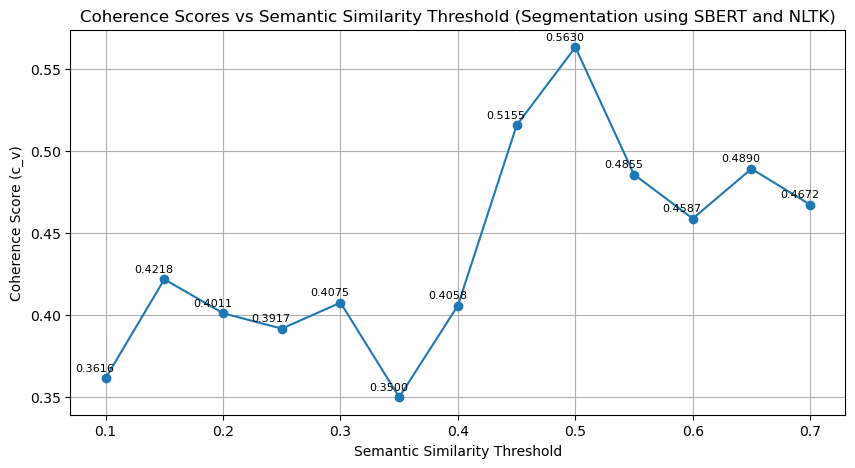

In [57]:
# Plotting
plt.figure(figsize=(10, 5))

thresholds_nltk = results_df['Threshold']
coherences_nltk = results_df['Coherence']

plt.plot(thresholds_nltk, coherences_nltk, marker='o')

offset = 0.003
for x, y in zip(thresholds_nltk, coherences_nltk):
    plt.text(x - 3*offset, y + offset, f'{y:.4f}', fontsize=8, ha='center', va='bottom')
    
plt.title('Coherence Scores vs Semantic Similarity Threshold (Segmentation using SBERT and NLTK)')
plt.xlabel('Semantic Similarity Threshold')
plt.ylabel('Coherence Score (c_v)')
plt.grid(True)
plt.show()

## Topic modeling and coherence score calculation for the semantic segmentation using SBERT and SpaCy's sentence boundary detection:

In [58]:
# Directory containing the segmented text files
directory = 'semantic_segmentation_sbert_spacy'

# Initialize a CountVectorizer
vectorizer_model = CountVectorizer(stop_words='english', ngram_range=(1,2))

umap_model = UMAP(n_neighbors=15, n_components=5, 
                  min_dist=0.0, metric='cosine', random_state=42)

# Prepare to collect threshold, coherence data, and number of topics
results = []

# Process each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Extract the threshold value from the file name
        threshold = float(filename.split('_')[-1][:-4])
        path = os.path.join(directory, filename)
        
        # Load the dataset
        df = pd.read_csv(path)
        documents = df['Segmented Text'].tolist()
        
        # Create a BERTopic model
        model = BERTopic(vectorizer_model=vectorizer_model, umap_model=umap_model, nr_topics="auto")
        
        # Fit the model
        topics, _ = model.fit_transform(documents)

        # Calculate the number of unique topics, excluding the outlier topic
        num_topics = len(set([topic for topic in topics if topic != -1]))

        # Extract topic words
        topic_words = [model.get_topic(topic) for topic in set(topics) if topic != -1]
        topic_words = [[word for word, _ in topic] for topic in topic_words]

        # Tokenize documents for Gensim
        tokenized_docs = [doc.split() for doc in documents]

        # Create a Gensim Dictionary and Corpus
        dictionary = Dictionary(tokenized_docs)
        corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

        # Use Gensim's CoherenceModel to compute coherence scores
        coherence_model = CoherenceModel(topics=topic_words, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()

        # Append results including the number of topics
        results.append([path, threshold, coherence_score, num_topics])
        print(f"Processed {path} with {num_topics} topics and coherence score: {coherence_score:.4f}")

# Save results to CSV
results_df = pd.DataFrame(results, columns=['File Path', 'Threshold', 'Coherence', 'Number of Topics'])
results_df.to_csv('coherence_scores_semantic_segmentation_sbert_spacy.csv', index=False)

Processed semantic_segmentation_sbert_spacy\semantic_segmentation_sbert_spacy_0.10.csv with 3 topics and coherence score: 0.3817
Processed semantic_segmentation_sbert_spacy\semantic_segmentation_sbert_spacy_0.15.csv with 4 topics and coherence score: 0.5081
Processed semantic_segmentation_sbert_spacy\semantic_segmentation_sbert_spacy_0.20.csv with 9 topics and coherence score: 0.3651
Processed semantic_segmentation_sbert_spacy\semantic_segmentation_sbert_spacy_0.25.csv with 9 topics and coherence score: 0.3673
Processed semantic_segmentation_sbert_spacy\semantic_segmentation_sbert_spacy_0.30.csv with 2 topics and coherence score: 0.4669
Processed semantic_segmentation_sbert_spacy\semantic_segmentation_sbert_spacy_0.35.csv with 6 topics and coherence score: 0.3005
Processed semantic_segmentation_sbert_spacy\semantic_segmentation_sbert_spacy_0.40.csv with 8 topics and coherence score: 0.4779
Processed semantic_segmentation_sbert_spacy\semantic_segmentation_sbert_spacy_0.45.csv with 13 to

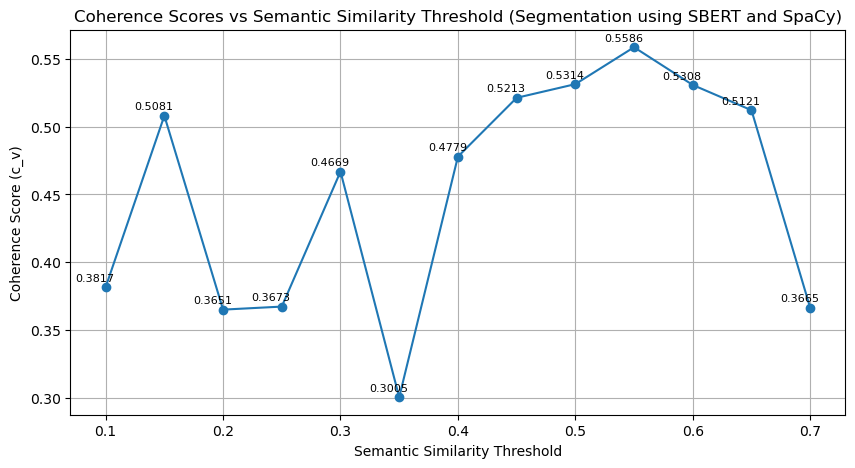

In [59]:
# Plotting
plt.figure(figsize=(10, 5))

thresholds_spacy = results_df['Threshold']
coherences_spacy = results_df['Coherence']

plt.plot(thresholds_spacy, coherences_spacy, marker='o')

offset = 0.003
for x, y in zip(thresholds_spacy, coherences_spacy):
    plt.text(x - 3*offset, y + offset, f'{y:.4f}', fontsize=8, ha='center', va='bottom')
    
plt.title('Coherence Scores vs Semantic Similarity Threshold (Segmentation using SBERT and SpaCy)')
plt.xlabel('Semantic Similarity Threshold')
plt.ylabel('Coherence Score (c_v)')
plt.grid(True)
plt.show()

## Topic modeling and coherence score calculation for the sentence segmentation using NLTK:

In [60]:
# File and directory setup
directory = '.'
filename = 'segmented_text_by_sentences_nltk.csv'
path = os.path.join(directory, filename)

# Load the dataset
df = pd.read_csv(path)
documents = df['Segmented Text'].tolist()

# Default UMAP parameters from BERTopic
n_components = 5
n_neighbors = 15

# Initialize a CountVectorizer
vectorizer_model = CountVectorizer(stop_words='english', ngram_range=(1,2))

umap_model = UMAP(n_neighbors=n_neighbors, n_components=n_components, min_dist=0.0, metric='cosine', random_state=42)
model = BERTopic(vectorizer_model=vectorizer_model, 
                 umap_model=umap_model, nr_topics="auto")

topics, _ = model.fit_transform(documents)

# Count the number of topics, excluding the outlier topic if present
num_topics = len(set(topics)) - (1 if -1 in topics else 0)

# Extract and process topics
topic_words = [model.get_topic(topic) for topic in set(topics) if topic != -1]
topic_words = [[word for word, _ in topic] for topic in topic_words]
tokenized_docs = [doc.split() for doc in documents]
dictionary = Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]
coherence_model = CoherenceModel(topics=topic_words, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

# Store results
results = [[path, coherence_score, num_topics]]
results_df = pd.DataFrame(results, columns=['File Path', 'Coherence', 'Number of Topics'])
results_df.to_csv('coherence_score_segmented_by_sentence_nltk.csv', index=False)
print(f"Processed {path} with {num_topics} topics and coherence score: {coherence_score:.4f}")

Processed .\segmented_text_by_sentences_nltk.csv with 13 topics and coherence score: 0.4719


## Topic modeling and coherence score calculation for the sentence segmentation using SpaCy:

In [61]:
# File and directory setup
directory = '.'
filename = 'segmented_text_by_sentences_spacy.csv'
path = os.path.join(directory, filename)

# Load the dataset
df = pd.read_csv(path)
documents = df['Segmented Text'].tolist()

# Default UMAP parameters from BERTopic
n_components = 5
n_neighbors = 15

# Initialize a CountVectorizer
vectorizer_model = CountVectorizer(stop_words='english', ngram_range=(1,2))

umap_model = UMAP(n_neighbors=n_neighbors, n_components=n_components, min_dist=0.0, metric='cosine', random_state=42)
model = BERTopic(vectorizer_model=vectorizer_model, 
                 umap_model=umap_model, nr_topics="auto")

topics, _ = model.fit_transform(documents)

# Count the number of topics, excluding the outlier topic if present
num_topics = len(set(topics)) - (1 if -1 in topics else 0)

# Extract and process topics
topic_words = [model.get_topic(topic) for topic in set(topics) if topic != -1]
topic_words = [[word for word, _ in topic] for topic in topic_words]
tokenized_docs = [doc.split() for doc in documents]
dictionary = Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]
coherence_model = CoherenceModel(topics=topic_words, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

# Store results
results = [[path, coherence_score, num_topics]]
results_df = pd.DataFrame(results, columns=['File Path', 'Coherence', 'Number of Topics'])
results_df.to_csv('coherence_score_segmented_by_sentence_spacy.csv', index=False)
print(f"Processed {path} with {num_topics} topics and coherence score: {coherence_score:.4f}")

Processed .\segmented_text_by_sentences_spacy.csv with 25 topics and coherence score: 0.4593


## Identifying the segmentation characteristics resulting in the highest coherence score:

In [62]:
# Files that store coherence scores
files = [
    'coherence_scores_semantic_segmentation_sbert_nltk.csv',
    'coherence_scores_semantic_segmentation_sbert_spacy.csv',
    'coherence_score_segmented_by_sentence_nltk.csv',
    'coherence_score_segmented_by_sentence_spacy.csv'
]

# Combine all data into a single DataFrame
all_data = pd.DataFrame()
for file in files:
    df = pd.read_csv(file)
    all_data = pd.concat([all_data, df], ignore_index=True)
    
# We want to have at least 10 topics in our topic model
# Filter the DataFrame for entries with at least 10 topics
filtered_data = all_data[all_data['Number of Topics'] >= 10]

max_coherence_row = filtered_data.loc[filtered_data['Coherence'].idxmax()]

# Store the file path in a variable
highest_coherence_file_path = max_coherence_row['File Path']
highest_coherence = max_coherence_row['Coherence']
print(f"The file with the highest coherence and at least 10 topics is: {highest_coherence_file_path} with a coherence value of {highest_coherence:.4f}")

%store highest_coherence_file_path

The file with the highest coherence and at least 10 topics is: semantic_segmentation_sbert_nltk\semantic_segmentation_sbert_nltk_0.50.csv with a coherence value of 0.5630
Stored 'highest_coherence_file_path' (str)


# Hyperparameter fine-tuning for BERTopic

## Grid search for UMAP parameters:

Processed (n_neighbors=5, n_components=2) with coherence score: 0.4758
Processed (n_neighbors=5, n_components=5) with coherence score: 0.4171
Processed (n_neighbors=5, n_components=10) with coherence score: 0.4647
Processed (n_neighbors=5, n_components=15) with coherence score: 0.4769
Processed (n_neighbors=10, n_components=2) with coherence score: 0.4724
Processed (n_neighbors=10, n_components=5) with coherence score: 0.4510
Processed (n_neighbors=10, n_components=10) with coherence score: 0.4553
Processed (n_neighbors=10, n_components=15) with coherence score: 0.4603
Processed (n_neighbors=15, n_components=2) with coherence score: 0.4642
Processed (n_neighbors=15, n_components=5) with coherence score: 0.5630
Processed (n_neighbors=15, n_components=10) with coherence score: 0.4710
Processed (n_neighbors=15, n_components=15) with coherence score: 0.4843
Processed (n_neighbors=20, n_components=2) with coherence score: 0.4806
Processed (n_neighbors=20, n_components=5) with coherence scor

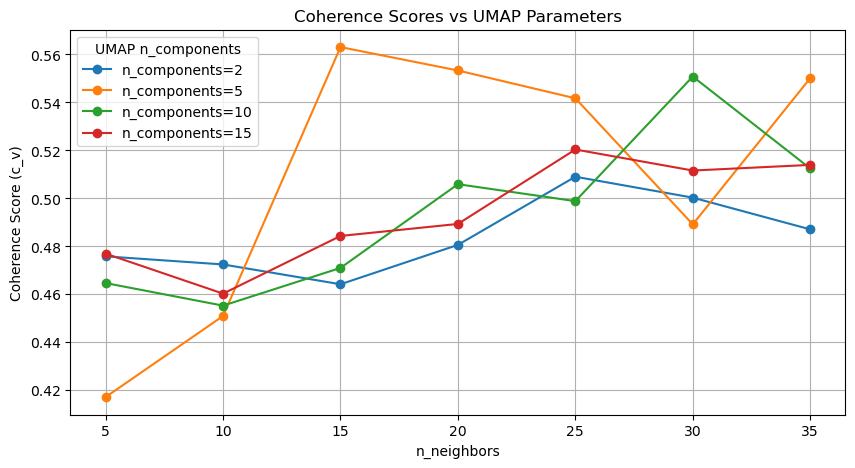

In [63]:
# Path of the file with the highest coherence score
%store -r highest_coherence_file_path 
path = highest_coherence_file_path

# Load the dataset
df = pd.read_csv(path)
documents = df['Segmented Text'].tolist()

# Grid search parameters
n_neighbors_options = [5, 10, 15, 20, 25, 30, 35]
n_components_options = [2, 5, 10, 15]

# Initialize a CountVectorizer
vectorizer_model = CountVectorizer(stop_words='english', ngram_range=(1,2))

# Prepare the plotting variables
results = []

# Perform the grid search
for n_neighbors, n_components in itertools.product(n_neighbors_options, n_components_options):
    umap_model = UMAP(n_neighbors=n_neighbors, n_components=n_components, min_dist=0.0, metric='cosine', random_state=42)
    model = BERTopic(vectorizer_model=vectorizer_model, umap_model=umap_model, nr_topics="auto")
    topics, _ = model.fit_transform(documents)
    num_topics = len(set([topic for topic in topics if topic != -1]))

    # Extract and process topics
    topic_words = [model.get_topic(topic) for topic in set(topics) if topic != -1]
    topics_list = [[word for word, _ in topic] for topic in topic_words]
    tokenized_docs = [doc.split() for doc in documents]
    dictionary = Dictionary(tokenized_docs)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]
    coherence_model = CoherenceModel(topics=topics_list, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()

    # Store results
    results.append([n_neighbors, n_components, coherence_score])
    print(f"Processed (n_neighbors={n_neighbors}, n_components={n_components}) with coherence score: {coherence_score:.4f}")

# Convert results to DataFrame and save
results_df = pd.DataFrame(results, columns=['n_neighbors', 'n_components', 'Coherence'])
results_df.to_csv('umap_parameters_coherence_scores_c_v.csv', index=False)

# Find the best parameters
best_params = results_df.loc[results_df['Coherence'].idxmax()]
best_n_neighbors = best_params['n_neighbors']
best_n_components = best_params['n_components']

# Store the best parameters for use in subsequent cells
%store best_n_neighbors
%store best_n_components

# Plotting results
plt.figure(figsize=(10, 5))
for label, df in results_df.groupby('n_components'):
    plt.plot(df['n_neighbors'], df['Coherence'], marker='o', label=f'n_components={label}')
plt.title('Coherence Scores vs UMAP Parameters')
plt.xlabel('n_neighbors')
plt.ylabel('Coherence Score (c_v)')
plt.legend(title='UMAP n_components')
plt.grid(True)
plt.show()

## Grid search for HDBSCAN parameters:

Error in coherence calculation: unable to interpret topic as either a list of tokens or a list of ids
Error in coherence calculation: unable to interpret topic as either a list of tokens or a list of ids
Processed with min_cluster_size=5, min_samples=5, 41 topics, coherence score: 0.5298
Processed with min_cluster_size=10, min_samples=1, 29 topics, coherence score: 0.4836
Processed with min_cluster_size=10, min_samples=5, 20 topics, coherence score: 0.4993
Processed with min_cluster_size=10, min_samples=10, 14 topics, coherence score: 0.5693
Processed with min_cluster_size=15, min_samples=1, 11 topics, coherence score: 0.5252
Processed with min_cluster_size=15, min_samples=7, 7 topics, coherence score: 0.4502
Processed with min_cluster_size=15, min_samples=15, 8 topics, coherence score: 0.4858
Processed with min_cluster_size=20, min_samples=2, 7 topics, coherence score: 0.4739
Processed with min_cluster_size=20, min_samples=10, 9 topics, coherence score: 0.5100
Processed with min_clust

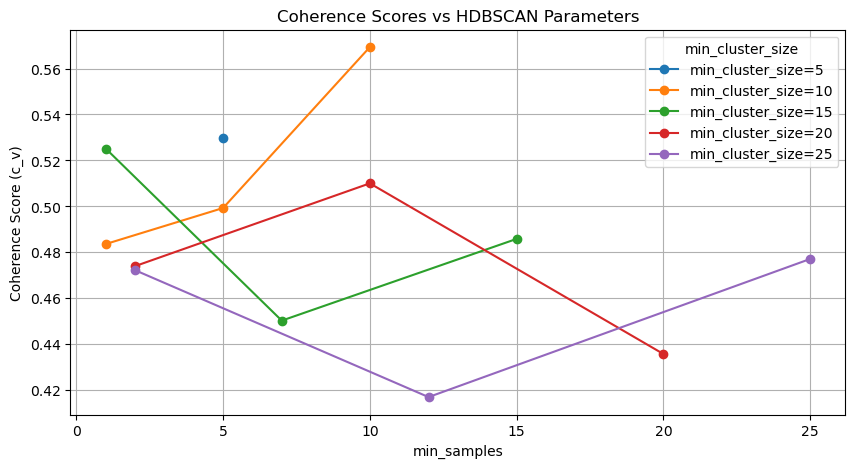

In [64]:
# Load the UMAP parameters
%store -r best_n_neighbors
%store -r best_n_components
n_neighbors = int(best_n_neighbors)
n_components = int(best_n_components)

# Load the path of the file with the highest coherence score
%store -r highest_coherence_file_path
path = highest_coherence_file_path

# Load the dataset
df = pd.read_csv(path)
documents = df['Segmented Text'].tolist()

# Initialize a CountVectorizer
vectorizer_model = CountVectorizer(stop_words='english', ngram_range=(1, 2))

# HDBSCAN parameters for grid search
min_cluster_size_options = [5, 10, 15, 20, 25]
min_samples_percentages = [10, 50, 100]  # percentages of the min_cluster_size

results = []  # Prepare the plotting variables

# Perform the grid search
for min_cluster_size in min_cluster_size_options:
    for percentage in min_samples_percentages:
        min_samples = max(1, int(min_cluster_size * (percentage / 100)))
        hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric='euclidean', prediction_data=True)
        umap_model = UMAP(n_neighbors=n_neighbors, n_components=n_components, min_dist=0.0, metric='cosine', random_state=42)
        model = BERTopic(vectorizer_model=vectorizer_model, umap_model=umap_model, hdbscan_model=hdbscan_model, nr_topics="auto")
        
        topics, _ = model.fit_transform(documents)
        num_topics = len(set(topics)) - (1 if -1 in topics else 0)

        # Extract and process topics
        topic_words = [model.get_topic(topic) for topic in set(topics) if topic != -1]
        topics_list = [[word for word, _ in topic] for topic in topic_words]
        tokenized_docs = [doc.split() for doc in documents]
        all_words = set(word for topic in topics_list for word in topic)  # Collect all unique words from topics
        tokenized_docs.extend([list(words) for words in all_words])  # Add words from topics as separate documents
        dictionary = Dictionary(tokenized_docs)
        corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

        # Compute coherence score
        try:
            coherence_model = CoherenceModel(topics=topics_list, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
            coherence_score = coherence_model.get_coherence()
            results.append([min_cluster_size, min_samples, num_topics, coherence_score])
            print(f"Processed with min_cluster_size={min_cluster_size}, min_samples={min_samples}, {num_topics} topics, coherence score: {coherence_score:.4f}")
        except Exception as e:
            print(f"Error in coherence calculation: {str(e)}")

# Save results to a DataFrame and CSV
results_df = pd.DataFrame(results, columns=['min_cluster_size', 'min_samples', 'Number of Topics', 'Coherence'])
results_df.to_csv('hdbscan_parameters_coherence_scores.csv', index=False)

# Identify the best parameters
best_params = results_df.loc[results_df['Coherence'].idxmax()]
best_min_cluster_size = best_params['min_cluster_size']
best_min_samples = best_params['min_samples']

# Store the best parameters for subsequent use
%store best_min_cluster_size
%store best_min_samples

# Visualize the results
plt.figure(figsize=(10, 5))
for label, df in results_df.groupby('min_cluster_size'):
    plt.plot(df['min_samples'], df['Coherence'], marker='o', label=f'min_cluster_size={label}')
plt.title('Coherence Scores vs HDBSCAN Parameters')
plt.xlabel('min_samples')
plt.ylabel('Coherence Score (c_v)')
plt.legend(title='min_cluster_size')
plt.grid(True)
plt.show()

# Topic modeling and screening

## Initial topic modeling using the identified best parameters: 

In [65]:
# UMAP parameters
%store -r best_n_neighbors
%store -r best_n_components
n_neighbors = int(best_n_neighbors)
n_components = int(best_n_components)

# HDBSCAN parameters
%store -r best_min_cluster_size
%store -r best_min_samples
min_cluster_size = int(best_min_cluster_size)
min_samples = int(best_min_samples)

# Path of the file with the highest coherence score
%store -r highest_coherence_file_path 
path = highest_coherence_file_path

# Load the dataset
df = pd.read_csv(path)
documents = df['Segmented Text'].tolist()

vectorizer_model = CountVectorizer(stop_words='english', ngram_range=(1,2))
umap_model = UMAP(n_neighbors=n_neighbors, n_components=n_components, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric='euclidean', prediction_data=True)

model = BERTopic(vectorizer_model=vectorizer_model, 
                 umap_model=umap_model, 
                 hdbscan_model=hdbscan_model, 
                 nr_topics="auto")

topics, _ = model.fit_transform(documents)

# Get the representative documents for each topic
representative_docs = model.get_representative_docs()

# Extract topics and their respective keywords
topic_keywords = model.get_topics()

# Prepare DataFrame for storing all data
topic_data = []

# Process each topic
for topic_num, keywords in topic_keywords.items():
    if topic_num == -1:
        continue  # skip the outlier topic

    # Format keywords and their weights
    keywords_formatted = ", ".join([f"{word} ({weight:.2f})" for word, weight in keywords])

    # Retrieve representative documents for this topic
    if topic_num in representative_docs:
        rep_docs = representative_docs[topic_num][:3]  # Get top 3 docs, if available
    else:
        rep_docs = [None, None, None]  # Default empty list if no docs available

    # Ensure there are always three documents (or None if fewer are available)
    rep_docs += [None] * (3 - len(rep_docs))

    # Store data
    topic_data.append({
        "Topic": topic_num,
        "Topic Information": keywords_formatted,
        "Representative Document 1": rep_docs[0],
        "Representative Document 2": rep_docs[1],
        "Representative Document 3": rep_docs[2]
    })

# Create a DataFrame
topics_df = pd.DataFrame(topic_data)

# Save to CSV
topics_df.to_csv('bertopic_results.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

print("BERTopic analysis results have been saved to 'bertopic_results.csv'.")

BERTopic analysis results have been saved to 'bertopic_results.csv'.


In [66]:
# Retrieve all topics and their keywords
all_topics = model.get_topics()

# Print each topic and its keywords
for topic_num, topic in all_topics.items():
    print(f"Topic #{topic_num}:")
    keywords = ', '.join([word for word, score in topic])
    print(keywords)

Topic #-1:
robot, data, security, network, access, computer, robots, attack, communication, attacks
Topic #0:
robot, robots, ros, data, access, computer, control, external, network, communication
Topic #1:
wifi, password, network, access, handshake, using, router, use, attacks, passwords
Topic #2:
attacks, data, attack, dos, access, security, network, authentication, compromise, attackers
Topic #3:
did, competition, okay, time, going, team, thats, phases, good, stage
Topic #4:
ros, master, ros master, ros network, nodes, network, authentication, communication, ros nodes, node
Topic #5:
construction, financial, excavators, excavator, construction site, site, project, delays, financial losses, losses
Topic #6:
lidar, sensor, data, sensors, sensor data, slam, lidar sensor, accelerometer, laser, readings
Topic #7:
turtlebot, burger, turtlebot3, limited, turtlebot3 burger, battery, turtlebots, power, battery life, processing power
Topic #8:
firmware, updates, update, software, firmware upda

## Topic screening and merging: 

Below, the irrelevant topics were merged with the outlier topic (Topic #-1) so that they would not be included in the final list of topics. Also, similar topics were merged to eliminate the duplication of topics. The topics to be merged should be updated whenever the dataset is updated based on the results in the previous cell. 

In [67]:
# Merge the irrelevant topics with the outlier topic (-1) and similar topics with each other
topics_to_merge = [[-1, 3],
                   [-1, 7],
                   [-1, 13],
                   [4, 9]]
model.merge_topics(documents, topics_to_merge)

# Retrieve all topics and their keywords
all_topics = model.get_topics()

# Print each topic and its keywords
for topic_num, topic in all_topics.items():
    print(f"Topic #{topic_num}:")
    keywords = ', '.join([word for word, score in topic])
    print(keywords)

Topic #-1:
robot, data, security, network, access, computer, robots, attack, communication, attacks
Topic #0:
robot, robots, ros, data, access, computer, control, network, external, communication
Topic #1:
wifi, password, network, access, using, handshake, router, use, attacks, passwords
Topic #2:
data, attacks, attack, access, dos, security, network, compromise, authentication, attackers
Topic #3:
ros, master, nodes, ros master, ros network, network, node, subscriber, topic, authentication
Topic #4:
construction, financial, excavators, excavator, construction site, site, project, delays, financial losses, losses
Topic #5:
lidar, sensor, data, sensors, sensor data, slam, lidar sensor, accelerometer, laser, readings
Topic #6:
firmware, updates, update, software, firmware update, firmware updates, regularly, security, raspberry, patches
Topic #7:
intrusion, intrusion detection, detection, suspicious, monitor, systems, traffic, network, prevention, ids
Topic #8:
project, construction, adv

## Visualizations for the screened topics:

In [84]:
num_topics = len(set(topics)) - (1 if -1 in topics else 0)
fig = model.visualize_barchart(top_n_topics=num_topics, width=360)

# Save the figure as a PNG file with specified resolution
fig.write_image("plot_high_res.png", width=1800, height=1000, scale=2)

model.visualize_barchart(top_n_topics=num_topics, width=360)

In [88]:
fig = model.visualize_topics()
fig.write_html("./intertopic_distance.html")

model.visualize_topics()

# Generating topic labels and summaries using LLMs

In [70]:
# This code includes GPT-4 by OpenAI as the LLM to generate labels and summaries for different topics
# Provide the OpenAI API key
config = configparser.ConfigParser()
config.read('config.ini') # The API key was stored in a configuration file to preserve confidentiality
api_key = config['DEFAULT']['OPENAI_API_KEY']

# Define the client for the OpenAI API
client = OpenAI(api_key=api_key)

# Retrieve the final list of topics after the screening
final_topics = model.get_topics()

# Retrieve the representative documents for the final list of topics after the screening
representative_docs = model.get_representative_docs()

# Retrieve the unique, existing topic IDs, excluding any outliers
unique_topics = set(final_topics.keys()) - {-1}

# Prepare to store results
topic_labels = []
topic_documents = {}

# Process each unique topic identified
for topic_id in unique_topics:
    # Get the keywords for the topic
    keywords = model.get_topic(topic_id)
    if keywords is None or not keywords:
        print(f"No keywords found for topic {topic_id}. Skipping.")
        continue
    keyword_list = ', '.join([f"{word} ({weight:.2f})" for word, weight in keywords])

    # Fetch representative documents using BERTopic's method
    if topic_id in representative_docs and representative_docs[topic_id]:
        representative_docs_per_topic = '\n\n'.join(representative_docs[topic_id])
    else:
        print(f"No representative documents found for topic {topic_id}. Skipping.")
        continue

    # Create the prompt for GPT-4
    prompt = f"""
    I have a topic that contains the following representative documents: \n{representative_docs_per_topic}
    The topic is described by the following keywords: {keyword_list}

    Can you summarize this topic with a label and a short paragraph?
    """

    # Send the prompt to GPT-4
    response = client.chat.completions.create(
        messages=[
            {"role": "user", "content": prompt}
        ],
        model="gpt-4-turbo",
        max_tokens=200,
        temperature=0 # The temperature parameter was set to 0 to make the output 
                      # as deterministic and reproducible as possible
    )

    # Extract the topic label suggested by GPT-4
    topic_label = response.choices[0].message.content.strip()
    topic_labels.append((topic_id, keyword_list, representative_docs_per_topic, topic_label))
    print(f"Topic {topic_id}: {topic_label}")
    print("\n---------\n")

Topic 0: **Label: Security Vulnerabilities in Robot Operating Systems**

**Summary:**
This topic explores various security threats and vulnerabilities within Robot Operating Systems (ROS) that could compromise robotic operations. Key vulnerabilities include the exploitation of weak authentication, buffer overflow attacks, and data integrity attacks through unauthorized access and message tampering. Attackers can manipulate ROS by introducing rogue nodes, intercepting sensor data, or conducting Denial of Service (DOS) and Man In The Middle (MITM) attacks. These security breaches can lead to incorrect robot navigation, unauthorized control, and potential mission failures, emphasizing the need for robust security measures in robotic systems.

---------

Topic 1: **Label: Wireless Network Hacking Techniques**

**Summary:**
This topic explores various wireless network hacking techniques using tools from the Kali Linux suite, such as Airodump-NG and Airgeddon. The hacking methods are categor

In [71]:
# Save the results to a DataFrame and then to a CSV file
df_labels = pd.DataFrame(topic_labels, columns=['Topic ID', 'Keywords', 'Representative Documents', 'Label'])
df_labels.to_csv('topic_labels_and_summaries_by_GPT.csv', index=False)
print("Labels and summaries saved to 'topic_labels_and_summaries_by_GPT.csv'.")

Labels and summaries saved to 'topic_labels_and_summaries_by_GPT.csv'.
